In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

In [2]:
def plot(model, X, resolution=100):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, resolution),
                         np.linspace(y_min, y_max, resolution))

    grid_points = np.c_[xx.ravel(), yy.ravel()]
    predictions = model.predict(grid_points)
    predictions = predictions.reshape(xx.shape)

    plt.contourf(xx, yy, predictions, alpha=0.0)
    plt.scatter(X[:, 0], X[:, 1], c=model.predict(X), s=5, cmap='plasma')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('EM Algorithm - Predictions')
    plt.show()

In [3]:
class EM:
  def __init__(self):
    self.mu = []
    self.sigma = []
    self.phi = []
    self.W = None
    self.sigma_inv = None
    self.sigma_dets = None
    self.classes = None

  def E_step(self):
    # Updating sigma_inv, sigma_dets
    for j in range(self.classes):
        # Regularizing sigma to avoid singularity issues
        self.sigma_inv[j] = np.linalg.inv(self.sigma[j] + 1e-6 * np.eye(self.X.shape[1]))
        self.sigma_dets[j] = np.linalg.det(self.sigma[j] + 1e-6 * np.eye(self.X.shape[1]))

    log_probs_cache = np.zeros((self.W.shape[0], self.classes))
    # Compute log probabilities
    for i in range(self.W.shape[0]):
        for j in range(self.classes):
            v = self.X[i] - self.mu[j]
            exponent = -0.5 * v.T @ self.sigma_inv[j] @ v
            log_coefficient = -0.5 * (self.X.shape[1] * np.log(2 * np.pi) + np.log(self.sigma_dets[j] + 1e-10))
            log_probs_cache[i, j] = np.log(self.phi[j] + 1e-10) + log_coefficient + exponent

    # Numerical stability
    max_log_probs = np.max(log_probs_cache, axis=1, keepdims=True)
    probs_cache_exp = np.exp(log_probs_cache - max_log_probs)
    sum_exp = np.sum(probs_cache_exp, axis=1, keepdims=True)

    self.W = probs_cache_exp / sum_exp


  def M_step(self):
    if self.semi:
      # Updating phis
      self.phi = ((np.sum(self.W, axis=0) + self.alpha*self.z_counts) / (self.n_samples + self.alpha*self.z_tilde.shape[0])).tolist()

      # Updating mu
      self.mu = []
      for j in range(self.classes):
          numerator = np.sum(self.W[:, j].reshape(-1, 1) * self.X, axis=0) + self.alpha * np.sum(self.X_tilde[self.z_tilde==j], axis=0)
          denominator = np.sum(self.W[:, j]) + self.alpha * self.z_counts[j]
          self.mu.append(numerator / (denominator + 1e-10))  # Add epsilon to prevent division by zero
      self.mu = np.array(self.mu)

      # Updating sigmas
      for j in range(self.classes):
        diff = self.X - self.mu[j]
        diff_tilde = self.X_tilde[self.z_tilde==j] - self.mu[j]
        weighted_diff = self.W[:, j].reshape(-1, 1) * diff
        numerator = weighted_diff.T @ diff + self.alpha * diff_tilde.T @ diff_tilde
        denominator = np.sum(self.W[:, j] + 1e-10) + self.alpha * self.z_counts[j]
        self.sigma[j] = numerator / denominator + 1e-6 * np.identity(self.X.shape[1])
    else:
      # Updating phis
      self.phi = (np.sum(self.W, axis=0) / (self.n_samples)).tolist()

      # Updating mu
      self.mu = []
      for j in range(self.classes):
          numerator = np.sum(self.W[:, j].reshape(-1, 1) * self.X, axis=0)
          denominator = np.sum(self.W[:, j])
          self.mu.append(numerator / (denominator + 1e-10))  # Add epsilon to prevent division by zero

      # Updating sigmas
      for j in range(self.classes):
        diff = self.X - self.mu[j]
        weighted_diff = self.W[:, j].reshape(-1, 1) * diff
        numerator = weighted_diff.T @ diff
        denominator = np.sum(self.W[:, j] + 1e-10)
        self.sigma[j] = numerator / denominator + 1e-6 * np.identity(self.X.shape[1])

  def calc_loss(self):
    log_likelihood = 0.0
    for j in range(self.classes):
        diff = self.X - self.mu[j]
        exponent = -0.5 * np.sum(diff @ self.sigma_inv[j] * diff, axis=1)
        coefficient = 1.0 / (np.power(2 * np.pi, self.n_features / 2) * np.sqrt(self.sigma_dets[j]))
        log_likelihood += self.phi[j] * coefficient * np.exp(exponent)

    log_likelihood = np.sum(np.log(log_likelihood + 1e-50))  # Avoid log(0)

    if self.semi:
        diff = X_tilde - self.mu[self.z_tilde]
        exponent = -0.5 * np.einsum('ij,ijk,ik->i', diff, self.sigma_inv[self.z_tilde], diff)
        coefficient = 1.0 / (np.sqrt((2 * np.pi) ** self.n_features * self.sigma_dets[self.z_tilde]))
        log_probs = np.log(coefficient) + exponent
        log_prob_sum = np.sum(log_probs)
        log_likelihood += self.alpha * log_prob_sum
    return log_likelihood

  def fit(self, X, n_classes, X_tilde = None, z_tilde = None, alpha = 0.5, tolerance=1e-4):
    self.X = X
    self.n_samples, self.n_features = self.X.shape
    self.classes = n_classes
    self.W = np.zeros((self.n_samples, self.classes))
    self.tolerance = tolerance

    # Semi-Supervised
    self.semi = X_tilde is not None
    if self.semi:
      self.X_tilde = X_tilde
      self.alpha = alpha
      _, self.z_tilde, self.z_counts = np.unique(z_tilde, return_inverse=True, return_counts=True)
      self.z_tilde = self.z_tilde.reshape(-1)

    # Intializations
    kmeans = KMeans(n_clusters=self.classes, random_state=0).fit(self.X)
    self.mu = kmeans.cluster_centers_
    self.sigma = np.array([np.identity(self.n_features) for _ in range(self.classes)])
    self.sigma_inv = np.array([np.identity(self.n_features) for _ in range(self.classes)])
    self.sigma_dets = np.ones(self.classes)
    self.phi = np.full(self.classes, 1.0 / self.classes)

    iters = 0
    diff = 1
    while(diff > self.tolerance):
      old_loss = self.calc_loss()
      # E-step
      self.E_step()
      # M-step
      self.M_step()
      iters += 1
      diff = self.calc_loss() - old_loss
    print(f'Number of Iterations: {iters}')



  def predict(self, X):
    n_samples, n_features = X.shape
    probs = np.zeros((n_samples, self.classes))
    for j in range(self.classes):
        diff = X - self.mu[j]
        exponent = -0.5 * np.sum(diff @ self.sigma_inv[j] * diff, axis=1)
        coefficient = 1.0 / (np.power(2 * np.pi, self.X.shape[1] / 2) * np.sqrt(self.sigma_dets[j]))
        probs[:, j] = np.log(self.phi[j] + 1e-10) + np.log(coefficient + 1e-10) + exponent
    return np.argmax(probs, axis=1)

In [4]:
df = pd.read_csv('ds3_train.csv')
df_val = pd.read_csv('ds3_valid.csv')
df_test = pd.read_csv('ds3_test.csv')

In [5]:
z = df.iloc[:, -1].to_numpy()

X = df.iloc[:, :-1].to_numpy()
X_train = X[z==-1]
X_tilde = X[z!=-1]
z_tilde = z[z!=-1]

X_val = df_val.iloc[:, :-1].to_numpy()
y_val = df_val.iloc[:, -1].to_numpy()

X_test = df_test.iloc[:, :-1].to_numpy()
y_val = df_val.iloc[:, -1].to_numpy()

Number of Iterations: 533


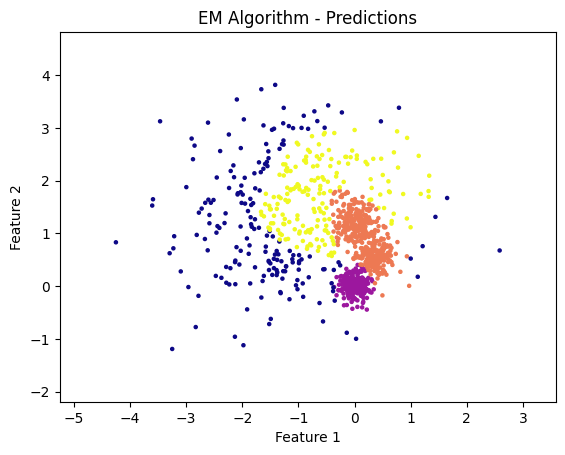

In [6]:
em_unsupervised = EM()
em_unsupervised.fit(X_train, 4)
plot(em_unsupervised, X_val)

Number of Iterations: 454


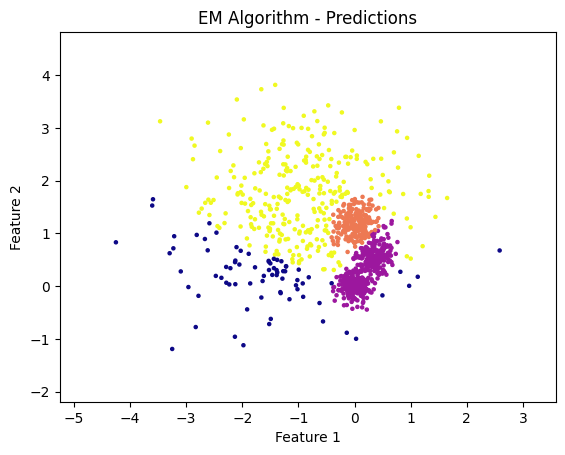

In [7]:
em_semi_supervised = EM()
em_semi_supervised.fit(X_train, 4, X_tilde, z_tilde, 1)
plot(em_semi_supervised, X_val)

Number of Iterations: 201


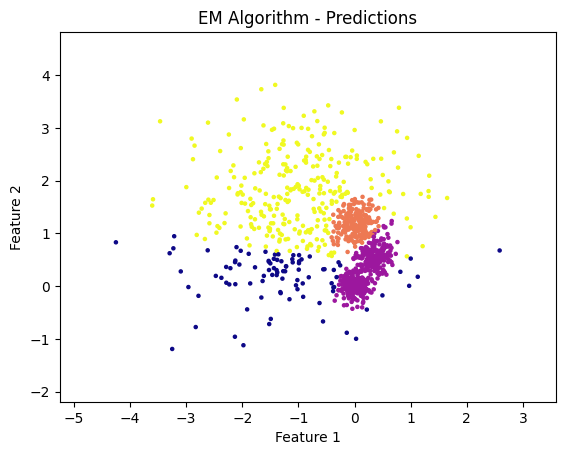

In [8]:
em_semi_supervised = EM()
em_semi_supervised.fit(X_train, 4, X_tilde, z_tilde, 5)
plot(em_semi_supervised, X_val)

Number of Iterations: 59


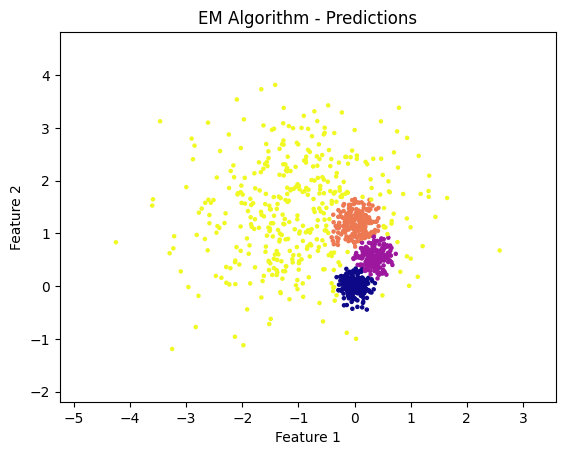

In [9]:
em_semi_unsupervised = EM()
em_semi_supervised.fit(X_train, 4, X_tilde, z_tilde, 10)
plot(em_semi_supervised, X_val)

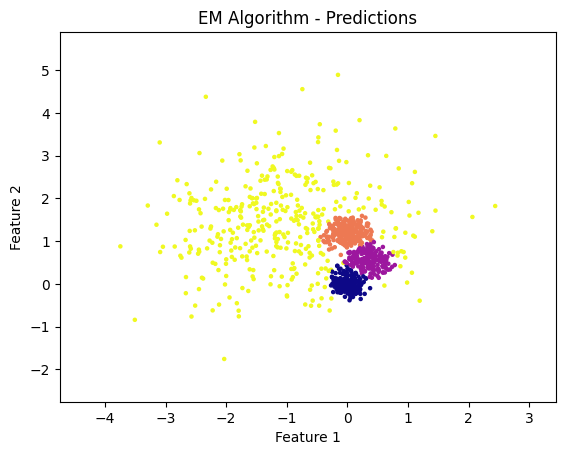

In [10]:
plot(em_semi_supervised, X_test)